# Import Library dan Data

In [ ]:
!pip install scipy==1.11.4
!pip install dalex
!pip install scikit-plot
!pip install shap
!pip install lime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import math
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.decomposition import PCA

import dalex as dx
import scikitplot as skplt
import shap
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/bank_churn_dataset/bank_churn_data.csv')
df.head()

user_id     attrition_flag  customer_age gender  dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  education_level marital_status income_category card_category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   months_on_book  ...  months_inactive_12_mon  contacts_count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   credit_limit  total_revolving_bal  avg_open_to_buy  total_amt_chng_q4_q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   total_trans_amt  total_trans_ct  total_ct_chng_q4_q1  avg_utilization_ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

In [ ]:
df.columns

Index(['user_id', 'attrition_flag', 'customer_age', 'gender',
       'dependent_count', 'education_level', 'marital_status',
       'income_category', 'card_category', 'months_on_book',
       'total_relationship_count', 'months_inactive_12_mon',
       'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal',
       'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt',
       'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio'],
      dtype='object')

# 1. Analisa beberapa pertanyaan berikut berdasarkan data yang diberikan:

## a. Seperti apa distribusi usia para nasabah? Usia manakah yang cenderung memiliki kemungkinan churn terbesar?

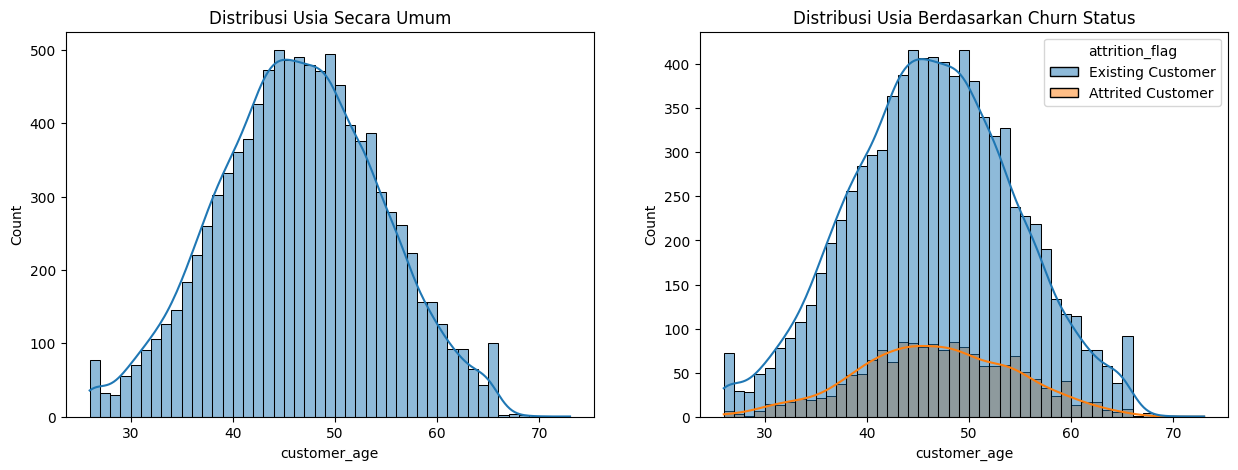

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (15,5))

sns.histplot(data = df, x='customer_age', kde=True, ax = axes[0])
axes[0].set_title('Distribusi Usia Secara Umum')

sns.histplot(data = df, x='customer_age', hue='attrition_flag', kde=True, ax = axes[1])
axes[1].set_title('Distribusi Usia Berdasarkan Churn Status')

plt.show()

Secara umum, usia dari customer cenderung terdistribusi secara normal. Artinya nilai mean dan median relatif sama. Berdasarkan visualisasi histogram yang kedua, kita bisa lihat bahwa pada data tersebut customer yang tidak churn jauh lebih banyak daripada yang churn. Adapun untuk rentang usia customer yang lebih banyak churn adalah pada sekitar rentang 43 - 50 tahun.

## b. Apakah terdapat korelasi antara tingkat pendidikan dan income category? Bagaimana korelasi dari kedua prediktor tersebut terhadap churn?

### I. Korelasi antara tingkat pendidikan dan income category.

Pertama kita akan cek apakah terdapat korelasi antara tingkat pendidikan dan income category. Artinya kita buat hypotesis sebagai berikut.

$H_0:$ Tidak ada hubungan antara tingkat pendidikan dan kategori pendapatan.

$H_1:$ Terdapat hubungan antara tingkat pendidikan dan kategori pendapatan.

Karena ini adalah data kategorikal, kita bisa gunakan uji chi square. Pertama kita akan buat tabel kontingensi.

In [ ]:
# Membuat urutan data
education_order = ['Unknown', 'Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']
df['education_level'] = pd.Categorical(df['education_level'], categories=education_order, ordered=True)

income_order = ['Unknown', 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']
df['income_category'] = pd.Categorical(df['income_category'], categories=income_order, ordered=True)

contingency_table = pd.crosstab(df['education_level'], df['income_category'])
contingency_table

income_category  Unknown  Less than $40K  $40K - $60K  $60K - $80K  \
education_level                                                      
Unknown              145             556          269          210   
Uneducated           185             522          249          195   
High School          225             671          355          307   
College              108             345          183          132   
Graduate             332            1139          553          422   
Post-Graduate         47             170          111           77   
Doctorate             70             158           70           59   

income_category  $80K - $120K  $120K +  
education_level                         
Unknown                   219      120  
Uneducated                217      119  
High School               308      147  
College                   175       70  
Graduate                  478      204  
Post-Graduate              81       30  
Doctorate                  57       37

Kemudian akan kita lakukan uji chi square.

In [ ]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Test antara Pendidikan dan Kategori Pendapatan")
print(f"Chi2: {chi2:.4f}, p-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Tolak hipotesis nol: Ada hubungan antara tingkat pendidikan dan kategori pendapatan.")
else:
    print("Gagal menolak hipotesis nol: Tidak ada hubungan antara tingkat pendidikan dan kategori pendapatan.")

Chi-Square Test antara Pendidikan dan Kategori Pendapatan
Chi2: 45.2537, p-value: 0.0366
Tolak hipotesis nol: Ada hubungan antara tingkat pendidikan dan kategori pendapatan.


Jika kita ambil nilai signifikansi alpha = 0.05, didapat bahwa terdapat hubungan antara tingkat pendidikan dan kategori pendapatan. Sekarang untuk mengukur seberapa kuat hubungan tersebut, kita bisa gunakan Cramer's V.

In [ ]:
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
print(f"Cramer's V: {cramers_v}")

Cramer's V: 0.0298952071841862


Cramer's V memiliki rentang antara 0 - 1. Sehingga karena Cramer's V pada data ini adalah 0.11, kita bisa simpulkan bahwa hubungan kedua variabel tersebut lemah.

### II. Korelasi dari kedua prediktor tersebut terhadap churn

Kita angkan gunakan cara yang sama yaitu menerapkan chi square test dengan hipotesis sebagai berikut.

$H_0:$ Tidak ada hubungan antara kombinasi tingkat pendidikan dan kategori pendapatan terhadap churn.

$H_1:$ Terdapat hubungan antara kombinasi tingkat pendidikan dan kategori pendapatan terhadap churn.

Pertama kita akan kombinasikan kolom education_level dan income_category dan membuat tabel kontingensinya.

In [ ]:
new_df = df.copy()
new_df['edu_income'] = new_df['education_level'].astype(str) + ' - ' + new_df['income_category'].astype(str)

order=[]
for x in education_order:
  for y in income_order:
    order.append(x + ' - ' + y)

new_df['edu_income'] = pd.Categorical(new_df['edu_income'], categories=order, ordered=True)

contingency_table2 = pd.crosstab(new_df['edu_income'], new_df['attrition_flag'])
contingency_table2

attrition_flag                  Attrited Customer  Existing Customer
edu_income                                                          
Unknown - Unknown                              27                118
Unknown - Less than $40K                       96                460
Unknown - $40K - $60K                          50                219
Unknown - $60K - $80K                          31                179
Unknown - $80K - $120K                         33                186
Unknown - $120K +                              19                101
Uneducated - Unknown                           32                153
Uneducated - Less than $40K                    80                442
Uneducated - $40K - $60K                       41                208
Uneducated - $60K - $80K                       24                171
Uneducated - $80K - $120K                      37                180
Uneducated - $120K +                           23                 96
High School - Unknown                          43                182
High School - Less than $40K                  101                570
High School - $40K - $60K                      51                304
High School - $60K - $80K                      42                265
High School - $80K - $120K                     41                267
High School - $120K +                          28                119
College - Unknown                              16                 92
College - Less than $40K                       49                296
College - $40K - $60K                          24                159
College - $60K - $80K                          17                115
College - $80K - $120K                         36                139
College - $120K +                              12                 58
Graduate - Unknown                             49                283
Graduate - Less than $40K                     210                929
Graduate - $40K - $60K                         77                476
Graduate - $60K - $80K                         52                370
Graduate - $80K - $120K                        67                411
Graduate - $120K +                             32                172
Post-Graduate - Unknown                         4                 43
Post-Graduate - Less than $40K                 34                136
Post-Graduate - $40K - $60K                    17                 94
Post-Graduate - $60K - $80K                    16                 61
Post-Graduate - $80K - $120K                   17                 64
Post-Graduate - $120K +                         4                 26
Doctorate - Unknown                            16                 54
Doctorate - Less than $40K                     42                116
Doctorate - $40K - $60K                        11                 59
Doctorate - $60K - $80K                         7                 52
Doctorate - $80K - $120K                       11                 46
Doctorate - $120K +                             8                 29

Kemudian, seperti biasa, kita akan hitung p value dari data tersebut.

In [ ]:
chi2, p, dof, expected = chi2_contingency(contingency_table2)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")

alpha = 0.05
if p < alpha:
    print("Terdapat hubungan signifikan antara kombinasi education level dan income category terhadap churn.")
else:
    print("Tidak terdapat hubungan signifikan antara kombinasi education level dan income category terhadap churn.")

Chi-Square Statistic: 56.52670816950223
P-Value: 0.053936249901945135
Degrees of Freedom: 41
Tidak terdapat hubungan signifikan antara kombinasi education level dan income category terhadap churn.


Diperoleh bahwa P value lebih dari alpha = 0.05, sehingga kita bisa simpulkan bahwa tidak ada hubungan antara kombinasi education level dan income category terhadap churn.

## c. Apakah terdapat perbedaan yang signifikan antara gender dengan kemungkinan nasabah untuk churn?

Karena kedua kolom tersebut adalah kategorikal, kita bisa uji perbedaan antara keduanya dengan menggunakan Chi square juga. Kita ambil hipotesis sebagai berikut.

$H_0:$ Tidak ada perbedaan yang signifikan antara gender dengan kemungkinan nasabah untuk churn.

$H_1:$ Terdapat perbedaan yang signifikan antara gender dengan kemungkinan nasabah untuk churn.

Lalu kita buat tabel kontingensi dari kedua kolom tersebut.

In [ ]:
contingency_table3 = pd.crosstab(df['gender'], df['attrition_flag'])
contingency_table3

attrition_flag  Attrited Customer  Existing Customer
gender                                              
F                             930               4428
M                             697               4072

In [ ]:
chi2, p, dof, expected = chi2_contingency(contingency_table3)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")

alpha = 0.05
if p < alpha:
    print("Terdapat perbedaan yang signifikan antara gender dengan kemungkinan nasabah untuk churn.")
else:
    print("Tidak ada perbedaan yang signifikan antara gender dengan kemungkinan nasabah untuk churn.")

Chi-Square Statistic: 13.86561370063734
P-Value: 0.00019635846717310307
Degrees of Freedom: 1
Terdapat perbedaan yang signifikan antara gender dengan kemungkinan nasabah untuk churn.


Bisa kita lihat bahwa P Value dari data ini lebih kecil dari nilai signifikansi alpha = 0.05. Oleh karena itu, dapat kita simpulkan bahwa kita menolak $H_0$ dan menerima $H_1$, artinya terdapat perbedaan yang signifikan antara gender dengan kemungkinan nasabah untuk churn.

## d. Apakah semakin lama customer menjadi nasabah maka semakin kecil kemungkinan nasabah tersebut untuk churn?

Karena kolom months_on_book itu numerikal sedangkan attrition_flag itu kategorikal, maka kita bisa gunakan pointbiserialr untuk mengecek hubungan kedua variabel tersebut. Kita tentukan hipotesis sebagai berikut.

$H_0:$ Tidak ada hubungan antara lama customer menjadi nasabah dengan churn.

$H_1:$ Terdapat hubungan antara lama customer menjadi nasabah dengan churn.

In [ ]:
new_df = df.loc[:, ['months_on_book', 'attrition_flag']]
new_df.loc[:, 'attrition_flag'] = new_df['attrition_flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

correlation, p_value = pointbiserialr(new_df['months_on_book'], new_df['attrition_flag'])

print(f"Point Biserial Correlation: {correlation}")
print(f"P-value: {p_value}")

alpha = 0.05
if p < alpha:
    print("Terdapat hubungan antara lama customer menjadi nasabah dengan churn.")
else:
    print("Tidak ada hubungan antara lama customer menjadi nasabah dengan churn.")

Point Biserial Correlation: 0.01368685117790972
P-value: 0.16843702876494404
Terdapat hubungan antara lama customer menjadi nasabah dengan churn.


Karena p value < alpha maka kita peroleh bahwa terdapat hubungan antara lama customer menjadi nasabah dengan churn. Jika kita lihat dari nilai korelasi nya yaitu 0.01 yang positif, kita tahu bahwa kedua variabel tersebut berkorelasi positif. Artinya semakin lama customer menjadi nasabah semakin tinggi pula peluang nasabah menjadi churn (karena kita set attrited customer = 1). Akan tetapi nilai 0.01 menunjukkan lemahnya hubungan tersebut.

## e. Apakah semakin sering customer berinteraksi dengan bank dalam 1 tahun terakhir mempengaruhi besar atau kecilnya kemungkinan nasabah untuk churn?

Kita bisa gunakan cara yang sama yaitu dengan pointbiserialr. Kita tentukan hipotesis sebagai berikut.

$H_0:$ Tidak ada hubungan antara jumlah interaksi dengan bank dalam 1 tahun terakhir dengan churn.

$H_1:$ Terdapat hubungan antara jumlah interaksi dengan bank dalam 1 tahun terakhir dengan churn.

In [ ]:
new_df = df.loc[:, ['contacts_count_12_mon', 'attrition_flag']]
new_df.loc[:, 'attrition_flag'] = new_df['attrition_flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

correlation, p_value = pointbiserialr(new_df['contacts_count_12_mon'], new_df['attrition_flag'])

print(f"Point Biserial Correlation: {correlation}")
print(f"P-value: {p_value}")

alpha = 0.05
if p < alpha:
    print("Terdapat hubungan antara jumlah interaksi dengan bank dalam 1 tahun terakhir dengan churn.")
else:
    print("Tidak ada hubungan antara jumlah interaksi dengan bank dalam 1 tahun terakhir dengan churn.")

Point Biserial Correlation: 0.20449050998160445
P-value: 4.697489630751521e-96
Terdapat hubungan antara jumlah interaksi dengan bank dalam 1 tahun terakhir dengan churn.


Kita peroleh bahwa p_value < alpha sehingga kita simpulkan bahwa terdapat hubungan antara jumlah interaksi dengan bank dalam 1 tahun terakhir dengan churn. Jika kita lihat dari nilai korelasinya yaitu 0.2 menunjukkan relasi yang positif dan cukup besar. Artinya semakin sering customer berinteraksi dengan bank justru semakin tinggi peluang customer untuk churn.

# 2. Buatlah model prediksi dengan menggunakan model machine learning (bebas, tidak dibatasi) dan evaluasi seberapa baik model yang anda buat. Catatan: soal ini akan dinilai berdasarkan apakah mentee sudah menggunakan workflow dengan benar

## Data Cleaning

### Missing Values

Pertama, kita akan cek apakah ada missing values pada data ini.

In [ ]:
pro = df.isnull().sum()/len(df)
data_pro = {'Missing Values Total':[x for x in df.isnull().sum()], 'Percentage': [str(round(x*100,2))+'%' for x in pro]}
percentage = pd.DataFrame(data_pro, index=list(df.columns))
percentage

Missing Values Total Percentage
user_id                                      0       0.0%
attrition_flag                               0       0.0%
customer_age                                 0       0.0%
gender                                       0       0.0%
dependent_count                              0       0.0%
education_level                              0       0.0%
marital_status                               0       0.0%
income_category                              0       0.0%
card_category                                0       0.0%
months_on_book                               0       0.0%
total_relationship_count                     0       0.0%
months_inactive_12_mon                       0       0.0%
contacts_count_12_mon                        0       0.0%
credit_limit                                 0       0.0%
total_revolving_bal                          0       0.0%
avg_open_to_buy                              0       0.0%
total_amt_chng_q4_q1                         0       0.0%
total_trans_amt                              0       0.0%
total_trans_ct                               0       0.0%
total_ct_chng_q4_q1                          0       0.0%
avg_utilization_ratio                        0       0.0%

Jika kita lihat, user_id sebenarnya tidak berpengaruh pada prediksi model sehingga lebih baik kita hapus kolom tersebut.

In [ ]:
df = df.drop('user_id', axis=1)

### Duplicated Values

Lalu kita cek apakah terdapat data duplikat pada df.

In [ ]:
num_dup = df.duplicated().sum()
per_dup = str(round(num_dup/len(df)*100,2)) + '%'

print(f'Jumlah nilai duplikat adalah {num_dup} yaitu {per_dup} dari keseluruhan data.')

Jumlah nilai duplikat adalah 0 yaitu 0.0% dari keseluruhan data.


### Encoding

Akan kita cek dahulu seperti apa unique values dari setiap kolom sebelum menentukan encoding yang akan dilakukan.

In [ ]:
categorical = df.select_dtypes(include=['object', 'category']).columns

for x in categorical:
  print(f'{x}:')
  print(f'{df[x].unique()}\n')

attrition_flag:
['Existing Customer' 'Attrited Customer']

gender:
['M' 'F']

education_level:
['High School', 'Graduate', 'Uneducated', 'Unknown', 'College', 'Post-Graduate', 'Doctorate']
Categories (7, object): ['Unknown' < 'Uneducated' < 'High School' < 'College' < 'Graduate' <
                         'Post-Graduate' < 'Doctorate']

marital_status:
['Married' 'Single' 'Unknown' 'Divorced']

income_category:
['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K', '$120K +', 'Unknown']
Categories (6, object): ['Unknown' < 'Less than $40K' < '$40K - $60K' < '$60K - $80K' <
                         '$80K - $120K' < '$120K +']

card_category:
['Blue' 'Gold' 'Silver' 'Platinum']



Kita akan ubah value dari kolom attrition_flag menjadi 1 untuk attrited customer dan 0 untuk existing customer. Kita juga akan ubah value kolom gender menjadi 1 untuk female dan 0 untuk male. Sedangkan untuk kolom lainnya, kita akan menggunakan one hot encoding.

In [ ]:
df_encoded = df.copy()

df_encoded.loc[:, 'attrition_flag'] = df_encoded['attrition_flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})
df_encoded['attrition_flag'] = df_encoded['attrition_flag'].astype(int)

df_encoded.loc[:, 'gender'] = df_encoded['gender'].map({'M': 0, 'F': 1})
df_encoded['gender'] = df_encoded['gender'].astype(int)

cols = ['education_level', 'marital_status', 'income_category', 'card_category']
df_encoded = pd.get_dummies(df_encoded, columns=cols, dtype=int)

df_encoded.head()

attrition_flag  customer_age  gender  dependent_count  months_on_book  \
0               0            45       0                3              39   
1               0            49       1                5              44   
2               0            51       0                3              36   
3               0            40       1                4              34   
4               0            40       0                3              21   

   total_relationship_count  months_inactive_12_mon  contacts_count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   credit_limit  total_revolving_bal  ...  income_category_Unknown  \
0       12691.0                  777  ...                        0   
1        8256.0                  864  ...                        0   
2        3418.0                    0  ...                        0   
3        3313.0                 2517  ...                        0   
4        4716.0                    0  ...                        0   

   income_category_Less than $40K  income_category_$40K - $60K  \
0                               0                            0   
1                               1                            0   
2                               0                            0   
3                               1                            0   
4                               0                            0   

   income_category_$60K - $80K  income_category_$80K - $120K  \
0                            1                             0   
1                            0                             0   
2                            0                             1   
3                            0                             0   
4                            1                             0   

   income_category_$120K +  card_category_Blue  card_category_Gold  \
0                        0                   1                   0   
1                        0                   1                   0   
2                        0                   1                   0   
3                        0                   1                   0   
4                        0                   1                   0   

   card_category_Platinum  card_category_Silver  
0                       0                     0  
1                       0                     0  
2                       0                     0  
3                       0                     0  
4                       0                     0  

[5 rows x 37 columns]

## Train Test Split

Kita akan membagi data menjadi 80% train dan 20% test.

In [ ]:
X = df_encoded.drop('attrition_flag', axis =1)
y = df_encoded['attrition_flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

customer_age  gender  dependent_count  months_on_book  \
9066            54       1                1              36   
5814            58       1                4              48   
792             45       1                4              36   
1791            34       1                2              36   
5011            49       1                2              39   

      total_relationship_count  months_inactive_12_mon  contacts_count_12_mon  \
9066                         1                       3                      3   
5814                         1                       4                      3   
792                          6                       1                      3   
1791                         4                       3                      4   
5011                         5                       3                      4   

      credit_limit  total_revolving_bal  avg_open_to_buy  ...  \
9066        3723.0                 1728           1995.0  ...   
5814        5396.0                 1803           3593.0  ...   
792        15987.0                 1648          14339.0  ...   
1791        3625.0                 2517           1108.0  ...   
5011        2720.0                 1926            794.0  ...   

      income_category_Unknown  income_category_Less than $40K  \
9066                        1                               0   
5814                        1                               0   
792                         0                               1   
1791                        0                               1   
5011                        0                               0   

      income_category_$40K - $60K  income_category_$60K - $80K  \
9066                            0                            0   
5814                            0                            0   
792                             0                            0   
1791                            0                            0   
5011                            1                            0   

      income_category_$80K - $120K  income_category_$120K +  \
9066                             0                        0   
5814                             0                        0   
792                              0                        0   
1791                             0                        0   
5011                             0                        0   

      card_category_Blue  card_category_Gold  card_category_Platinum  \
9066                   1                   0                       0   
5814                   1                   0                       0   
792                    0                   1                       0   
1791                   1                   0                       0   
5011                   1                   0                       0   

      card_category_Silver  
9066                     0  
5814                     0  
792                      0  
1791                     0  
5011                     0  

[5 rows x 36 columns]

## Exploratory Data Analysis

Agar mudah diinterpretasi, untuk keperluan analisis, kita akan menggunakan df sebelum di encode. Namun, kita ambil pada id dari X_train untuk menghindari data leakage.

In [ ]:
id = X_train.index
df_temp = df.loc[id]
df_temp.head()

attrition_flag  customer_age gender  dependent_count education_level  \
9066  Existing Customer            54      F                1         Unknown   
5814  Attrited Customer            58      F                4     High School   
792   Existing Customer            45      F                4         Unknown   
1791  Existing Customer            34      F                2        Graduate   
5011  Existing Customer            49      F                2     High School   

     marital_status income_category card_category  months_on_book  \
9066         Single         Unknown          Blue              36   
5814        Married         Unknown          Blue              48   
792          Single  Less than $40K          Gold              36   
1791         Single  Less than $40K          Blue              36   
5011        Married     $40K - $60K          Blue              39   

      total_relationship_count  months_inactive_12_mon  contacts_count_12_mon  \
9066                         1                       3                      3   
5814                         1                       4                      3   
792                          6                       1                      3   
1791                         4                       3                      4   
5011                         5                       3                      4   

      credit_limit  total_revolving_bal  avg_open_to_buy  \
9066        3723.0                 1728           1995.0   
5814        5396.0                 1803           3593.0   
792        15987.0                 1648          14339.0   
1791        3625.0                 2517           1108.0   
5011        2720.0                 1926            794.0   

      total_amt_chng_q4_q1  total_trans_amt  total_trans_ct  \
9066                 0.595             8554              99   
5814                 0.493             2107              39   
792                  0.732             1436              36   
1791                 1.158             2616              46   
5011                 0.602             3806              61   

      total_ct_chng_q4_q1  avg_utilization_ratio  
9066                0.678                  0.464  
5814                0.393                  0.334  
792                 1.250                  0.103  
1791                1.300                  0.694  
5011                0.794                  0.708

### Categorical Data

Pertama, kita akan analisa data kategorikal dahulu.

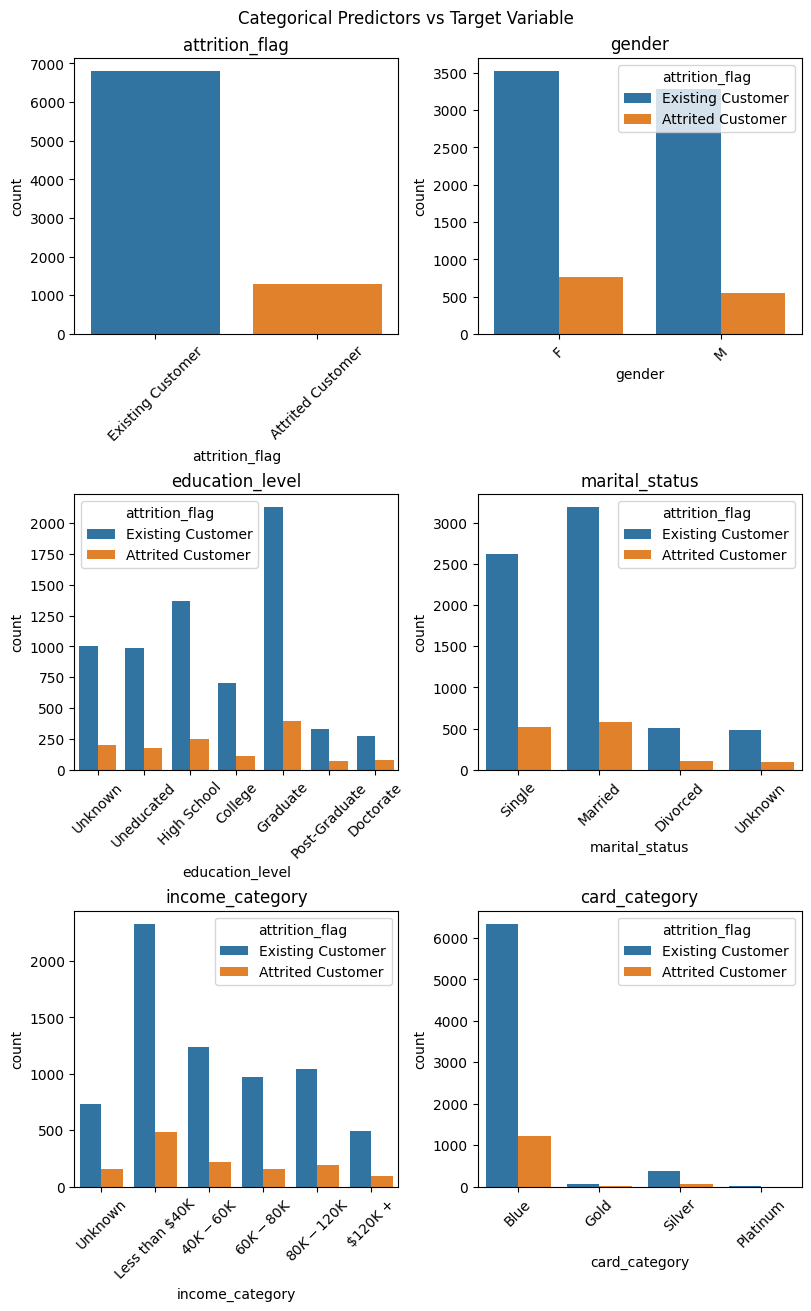

In [ ]:
categorical = df.select_dtypes(include=['object', 'category']).columns

fig, axes = plt.subplots(3,2, sharex=False, sharey = False, figsize=(8, 13), constrained_layout = True)

fig.suptitle('Categorical Predictors vs Target Variable')

col_index = 0

for row in range(3):
  for col in range(2):
    sns.countplot(ax = axes[row,col], x=df_temp[categorical[col_index]], hue=df_temp['attrition_flag'])
    axes[row, col].set_title(categorical[col_index])
    axes[row, col].tick_params(axis='x', rotation=45)
    col_index += 1

plt.show()

Secara umum dapat kita lihat bahwa jumlah customer yang tidak churn pada setiap feature jauh lebih tinggi daripada yang churn. Tentunya hal ini disebabkan oleh data yang tak seimbang karena memang data customer tidak churn jauh lebih banyak. Jika kita lihat rasio churn dan tidak churn berdasarkan gender, kita dapat ratio yang relatif sama. Berdasarkan tingkat pendidikan, graduate memiliki peluang tidak churn paling tinggi sedangkan doctorate yang paling rendah. Pada marital status, orang yang sudah menikah memiliki kecenderungan tidak churn paling tinggi. Di sisi lain, orang dengan penghasilan kurang dari 40 ribu dollar memiliki proporsi tidak churn paling tinggi pada feature kategori pendapatan. Adapaun untuk kategori kartu, kartu biru lah yang paling tinggi angkat tidak churnnya.

### Numerical Data

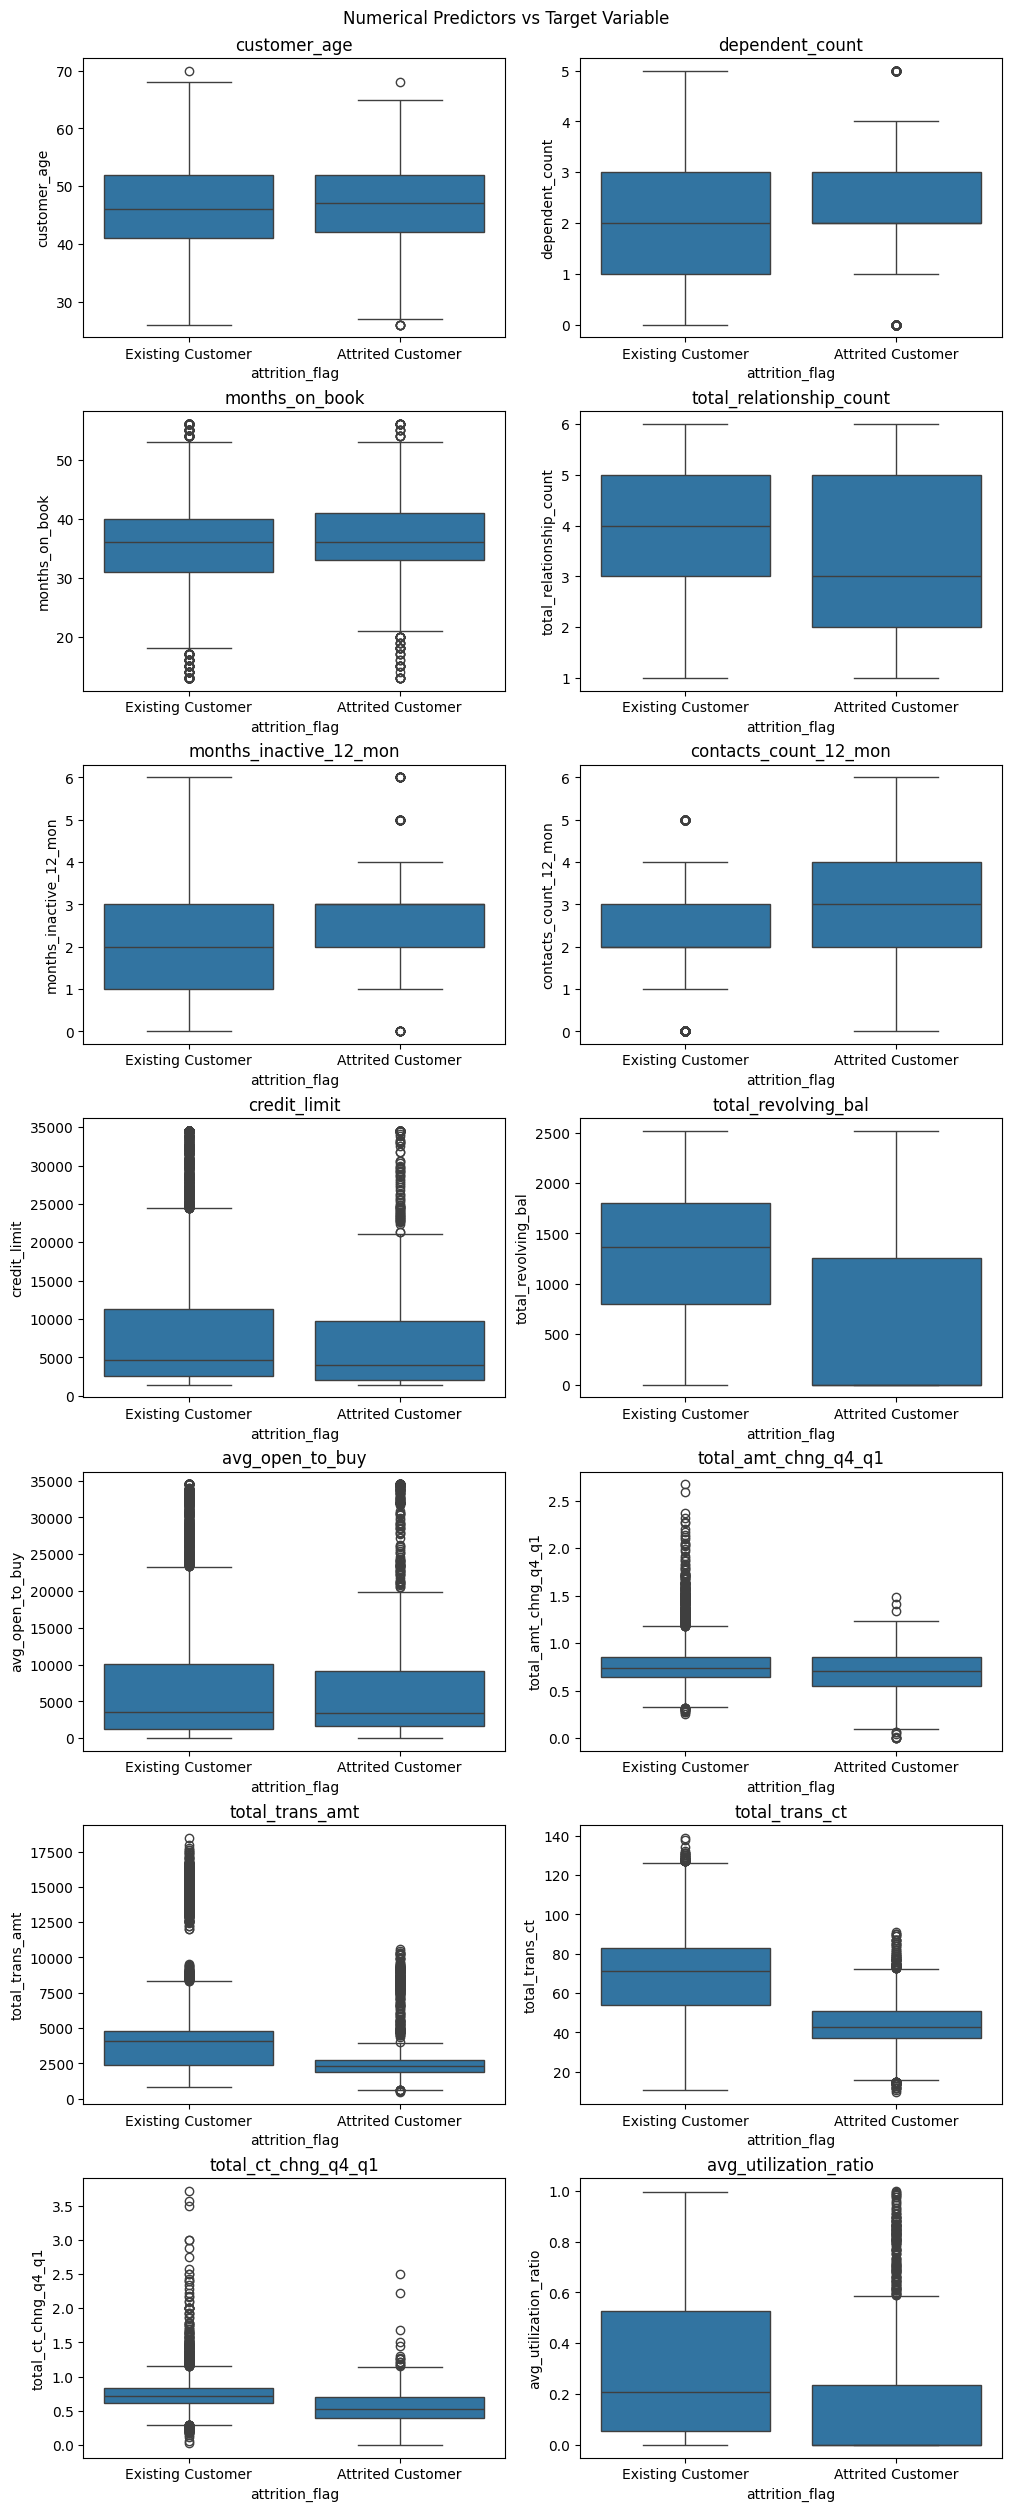

In [ ]:
numerical = df_temp.select_dtypes(include=['number']).columns

fig, axes = plt.subplots(7,2, sharex=False, sharey = False, figsize=(10,25), constrained_layout = True)

fig.suptitle('Numerical Predictors vs Target Variable')

col_index = 0

for row in range(7):
  for col in range(2):
    sns.boxplot(ax = axes[row,col], x=df_temp['attrition_flag'], y = df_temp[numerical[col_index]])
    axes[row,col].set_title(numerical[col_index])
    col_index += 1

Bisa kita lihat bahwa semua feature memiliki outlier kecuali  feature total_relationship_count dan total_revolving_bal. Pada customer_age, kita mengetahui bahwa nilai tengah dari usia customer baik yang churn maupun tidak hampir sama dimana pada customer churn terdapat outliers lebih banyak daripada yang tidak churn. Pola median yang hampir sama juga terlihat pada kolom lain yaitu months_on_book, credit_limit, total_amt_chng_q4_q1, dan total_ct_chng_q4_q1. Sedangkan pada dependent_count, terlihat bahwa data yang memiliki outliers hanya pada data yang churn saja. Tidak adanya garis tengah pada kolom ini untuk customer churn menunjukkan bahwa Q1, Q3, dan median yang hampir sama. Hal ini juga terjadi pada attrited customer di months_inactive_12_mon, existing customer di contacts_count_12_mon, attrited customer di total_revolving_bal, dan attrited customer di avg_utilization_ratio. Umumnya, rentang paling luas ada pada existing customer, namun terdapat beberapa feature yang sebaliknya yaitu pada total_relationship_count dan contacts_count_12_mon.

## Data Preprocessing

### Outliers

Sebagaimana yang kita lihat pada visualisasi di atas, terdapat banyak features yang memiliki outliers. Oleh karena itu, kita akan mengatasinya dengan log transformation. Namun sebelum itu,kita visualisasi kembali boxplot tersebut pada kolom numerik namun secara general (tidak terpisah antara churn maupun tidak churn)

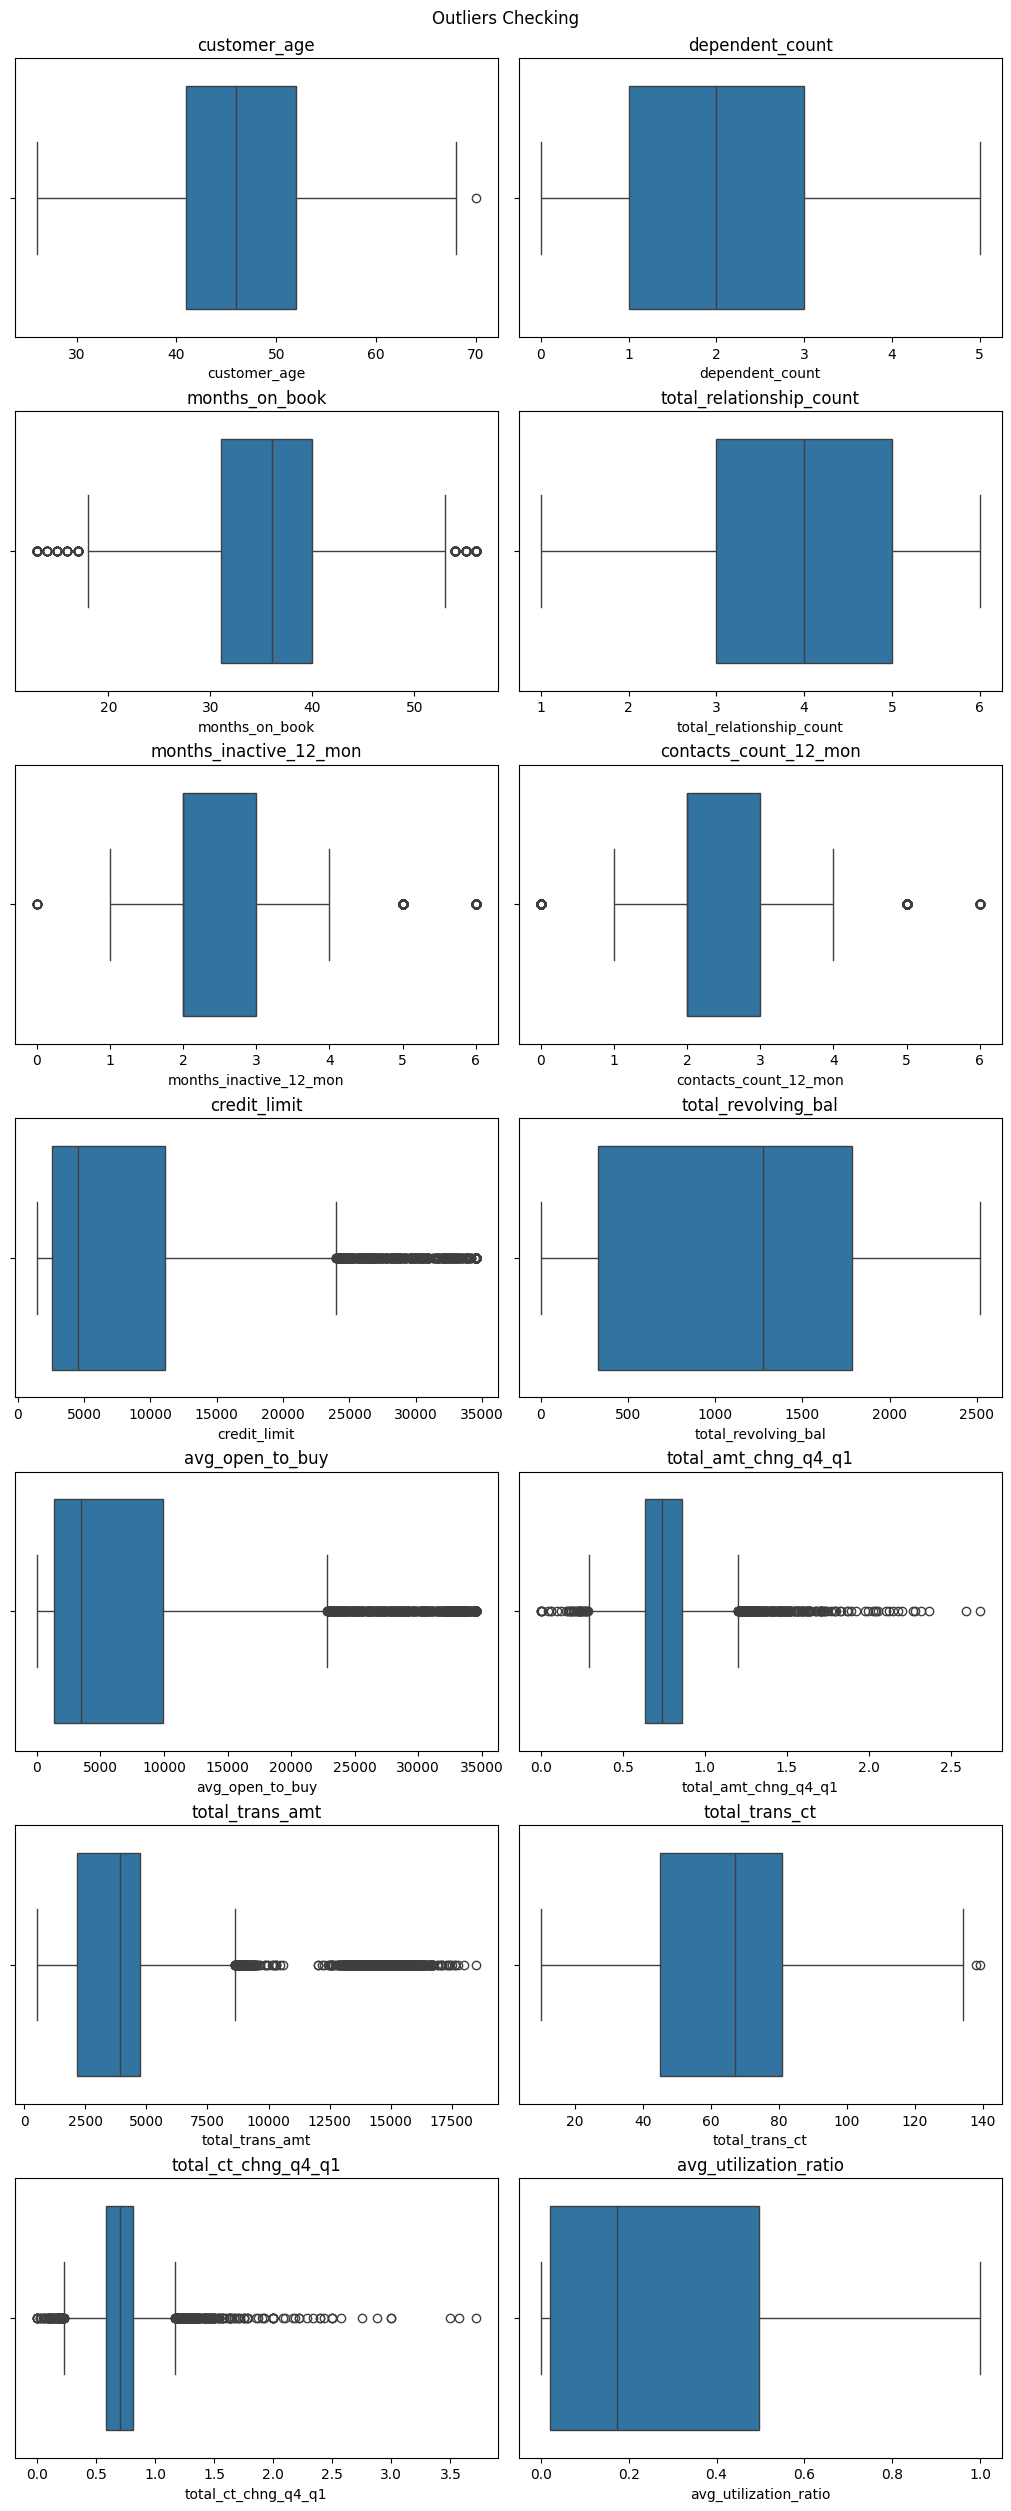

In [ ]:
fig, axes = plt.subplots(7,2, sharex=False, sharey = False, figsize=(10,25), constrained_layout = True)

fig.suptitle('Outliers Checking')

col_index = 0

for row in range(7):
  for col in range(2):
    sns.boxplot(ax = axes[row,col], x=X_train[numerical[col_index]])
    axes[row,col].set_title(numerical[col_index])
    col_index += 1

Karena pada customer age dan total_trans_ct outliers hanya sedikit, kita akan lakukan imputasi dengan median. Sedangkan pada kolom lain yang memiliki outliers, kita akan lakukan log transformation.

In [ ]:
# Kolom customer_age
Q1 = X_train['customer_age'].quantile(0.25)
Q3 = X_train['customer_age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_value = X_train['customer_age'].median()
X_train['customer_age'] = X_train['customer_age'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

# Kolom total_trans_ct
Q1 = X_train['total_trans_ct'].quantile(0.25)
Q3 = X_train['total_trans_ct'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

median_value = X_train['total_trans_ct'].median()
X_train['total_trans_ct'] = X_train['total_trans_ct'].apply(lambda x: median_value if x < lower_bound or x > upper_bound else x)

# Log transformation
cols = ['months_on_book', 'months_inactive_12_mon',
        'contacts_count_12_mon', 'credit_limit', 'avg_open_to_buy',
        'total_amt_chng_q4_q1', 'total_trans_amt',
        'total_ct_chng_q4_q1']

X_train[cols] = np.log(X_train[cols] + 1)
X_test[cols] = np.log(X_test[cols] + 1) # untuk transformasi, harus dilakukan juga pada test

### Mutlicollinearity

Sekarang kita akan cek multicollinearity dari kolom - kolom pada data.

In [ ]:
df_temp = pd.concat([X_train, y_train], axis=1)
df_temp.corr().style.background_gradient(cmap='coolwarm')

Kita dapat bahwa card_category_silver dan card_category_blue memiliki harga mutlak korelasi di atas 0.8. Sedangkan harga mutlak korelasi mereka terhadap attrition_flag secara berurutan adalah 0.014 dan 0.008. Karena korelasi card_category_silver dengan attrition_flag lebih besar dari card_category_blue dengan attrition_flag, maka kita drop kolom card_category_blue. Kita juga mengetahui bahwa korelasi (avg_open_to_buy, credit_limit) dan (total_trans_amt, total_trans_ct) memiliki harga mutlak di atas 0.9. Dengan cara yang sama yaitu dengan cek korelasi terhadap attrition_flag, kita akan drop avg_open_to_buy dan total_trans_amt.

In [ ]:
X_train = X_train.drop(['card_category_Blue', 'avg_open_to_buy', 'total_trans_amt'], axis=1)
X_test = X_test.drop(['card_category_Blue', 'avg_open_to_buy', 'total_trans_amt'], axis=1)
X_train.head()

customer_age  gender  dependent_count  months_on_book  \
9066          54.0       1                1        3.610918   
5814          58.0       1                4        3.891820   
792           45.0       1                4        3.610918   
1791          34.0       1                2        3.610918   
5011          49.0       1                2        3.688879   

      total_relationship_count  months_inactive_12_mon  contacts_count_12_mon  \
9066                         1                1.386294               1.386294   
5814                         1                1.609438               1.386294   
792                          6                0.693147               1.386294   
1791                         4                1.386294               1.609438   
5011                         5                1.386294               1.609438   

      credit_limit  total_revolving_bal  total_amt_chng_q4_q1  ...  \
9066      8.222554                 1728              0.466874  ...   
5814      8.593599                 1803              0.400788  ...   
792       9.679594                 1648              0.549277  ...   
1791      8.195885                 2517              0.769182  ...   
5011      7.908755                 1926              0.471253  ...   

      marital_status_Unknown  income_category_Unknown  \
9066                       0                        1   
5814                       0                        1   
792                        0                        0   
1791                       0                        0   
5011                       0                        0   

      income_category_Less than $40K  income_category_$40K - $60K  \
9066                               0                            0   
5814                               0                            0   
792                                1                            0   
1791                               1                            0   
5011                               0                            1   

      income_category_$60K - $80K  income_category_$80K - $120K  \
9066                            0                             0   
5814                            0                             0   
792                             0                             0   
1791                            0                             0   
5011                            0                             0   

      income_category_$120K +  card_category_Gold  card_category_Platinum  \
9066                        0                   0                       0   
5814                        0                   0                       0   
792                         0                   1                       0   
1791                        0                   0                       0   
5011                        0                   0                       0   

      card_category_Silver  
9066                     0  
5814                     0  
792                      0  
1791                     0  
5011                     0  

[5 rows x 33 columns]

### Scaling

Karena rentang pada setiap kolomnya bervariasi, kita akan melakukan scaling menggunakan standard scaler pada kolom-kolom numerik. Karena kita sudah membuat variabel numerik, kita bisa gunakan itu dengan menghapus kolom-kolom yang sudah di drop.

In [ ]:
numerical = numerical.drop(['avg_open_to_buy', 'total_trans_amt'])
scaler = StandardScaler()

X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])
X_train.head()

customer_age  gender  dependent_count  months_on_book  \
9066      0.959947       1        -1.035122        0.119212   
5814      1.458843       1         1.291390        1.296311   
792      -0.162568       1         1.291390        0.119212   
1791     -1.534530       1        -0.259618        0.119212   
5011      0.336328       1        -0.259618        0.445904   

      total_relationship_count  months_inactive_12_mon  contacts_count_12_mon  \
9066                 -1.812952                0.725882               0.559429   
5814                 -1.812952                1.446203               0.559429   
792                   1.409234               -1.511637               0.559429   
1791                  0.120360                0.725882               1.156686   
5011                  0.764797                0.725882               1.156686   

      credit_limit  total_revolving_bal  total_amt_chng_q4_q1  ...  \
9066     -0.407175             0.696075             -0.784481  ...   
5814     -0.010361             0.788048             -1.348852  ...   
792       1.151058             0.597970             -0.080765  ...   
1791     -0.435695             1.663634              1.797207  ...   
5011     -0.742768             0.938885             -0.747084  ...   

      marital_status_Unknown  income_category_Unknown  \
9066                       0                        1   
5814                       0                        1   
792                        0                        0   
1791                       0                        0   
5011                       0                        0   

      income_category_Less than $40K  income_category_$40K - $60K  \
9066                               0                            0   
5814                               0                            0   
792                                1                            0   
1791                               1                            0   
5011                               0                            1   

      income_category_$60K - $80K  income_category_$80K - $120K  \
9066                            0                             0   
5814                            0                             0   
792                             0                             0   
1791                            0                             0   
5011                            0                             0   

      income_category_$120K +  card_category_Gold  card_category_Platinum  \
9066                        0                   0                       0   
5814                        0                   0                       0   
792                         0                   1                       0   
1791                        0                   0                       0   
5011                        0                   0                       0   

      card_category_Silver  
9066                     0  
5814                     0  
792                      0  
1791                     0  
5011                     0  

[5 rows x 33 columns]

### Oversampling

In [ ]:
y_train.value_counts()

attrition_flag
0    6801
1    1300
Name: count, dtype: int64

Seperti yang kita tahu, data ini imbalance sehingga kita akan melakukan oversampling dengan menggunakan SMOTE hanya pada data train. Sedangkan untuk data test, kita biarkan original.

In [ ]:
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
y_train.value_counts()

attrition_flag
0    6801
1    6801
Name: count, dtype: int64

## Model Training

Sekarang kita akan melakukan model training. Adapun model yang kita pakai adalah XGBClassifier. Kita juga akan melakukan grid search cv untuk menentukan parameter apa yang terbaik untuk kasus ini. Kita berusaha untuk menghindari customer yang churn diprediksi tidak churn (false negative) karena perusahaan berusaha untuk mencegah customer agar tidak churn. Sedangkan apabila customer yang tidak churn diprediksi sebagai churn (false positive) maka hal itu tidak terlalu bermasalah karena sebagai antisipasi. Oleh karena itu, metrik utama yang dipakai untuk kasus ini khususnya pada grid search cv adalah recall.

In [ ]:
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train)

parameter = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb,
                           param_grid=parameter,
                           scoring='recall',
                           cv=5)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-validation Score:", best_score)

xgb_best = grid_search.best_estimator_

Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
Best Cross-validation Score: 0.94220847560185


## Model Evaluation

In [ ]:
y_pred_xgb_train = xgb_best.predict(X_train)
xgb_train = recall_score(y_train, y_pred_xgb_train)

y_pred_xgb_test = xgb_best.predict(X_test)
xgb_test = recall_score(y_test, y_pred_xgb_test)

result = pd.DataFrame({'Dataset' : ['Train', 'Test'],
                       'Score' : [xgb_train, xgb_test]})
result

Dataset     Score
0   Train  0.965887
1    Test  0.773700

Terlihat bahwasanya model masih overfit karena recall score pada data train jauh lebih baik daripada recall score pada data test. Sehingga masih perlu mengolah model lebih baik lagi seperti menambah dataset khususnya data churn, mencoba hyperparameter tuning lebih banyak, dan mencoba model lain yang lebih sederhana.

# 3. Anda ingin meyakinkan stakeholder anda bahwa model yang anda gunakan itu akan lebih baik dalam mengidentifikasi customer yang akan churn dibandingkan tanpa menggunakan model. Apa metrik yang dapat anda gunakan untuk membuktikan hal ini?

Bila kita memprediksi data customer tanpa menggunakan model, maka diperlukan waktu yang lama hanya untuk menganalisa sebagian data. Sedangkan dengan menggunakan model, kita bisa menghasilkan prediksi dengan sangat cepat. Sehingga jelas dalam hal kecepatan, menggunakan model lebih baik daripada tanpa menggunakan model.

Dalam hal menguji kualitas dari model yang dibuat, kita bisa menggunakan confusion matrix yang bisa menghitung berapa banyak true positive, true negative, false positive, dan false negative yang kita buat. Sehingga kita bisa lebih objektif dalam menguji kualitas prediksi.

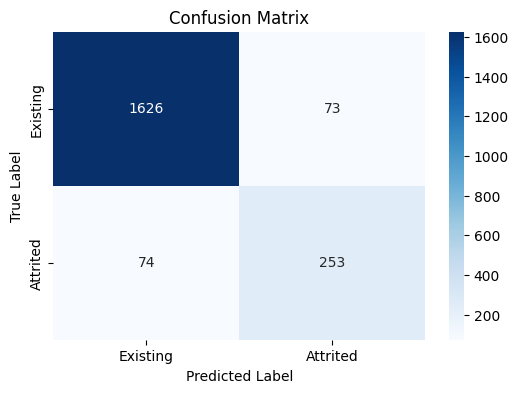

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb_test)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',  xticklabels=['Existing', 'Attrited'], yticklabels=['Existing', 'Attrited'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Adapun metrik yang lebih utama dalam kasus ini adalah Recall. Kita berusaha untuk menghindari customer yang churn diprediksi tidak churn (false negative) karena perusahaan berusaha untuk mencegah customer agar tidak churn. Sedangkan apabila customer yang tidak churn diprediksi sebagai churn (false positive) maka hal itu tidak terlalu bermasalah karena sebagai antisipasi. Oleh karena itu, metrik utama yang dipakai untuk kasus ini adalah recall.

Dalam kasus ini didapat bahwa model cukup mampu memprediksi true positive sebanyak 256 dari 327 data yang sebenarnya positif attrited atau sekitar 78.3% dari data yang sebenarnya positif (recall). Meskipun demikian, kita tetap perlu untuk meningkatkan performa model karena masih terdapat 74 false negative dari 327 data yang sebenarnya positif.

# 4. (Open-Ended) Karena stakeholder anda membutuhkan knowledge dari model, analisislah model yang anda buat dengan menggunakan explanatory model analysis dan buatlah rekomendasi-rekomendasi berdasarkan hasil dari analisis tersebut.


Karena model XGBoost adalah model yang tidak mudah diinterpretasi, maka kita akan menganalisa model dengan metode model agnostic.

## Permutation Feature Importance

In [ ]:
data_explainer = dx.Explainer(xgb_best, X_train, y_train, label = "XGBoost Interpretation")
data_explainer.model_parts().plot()

Preparation of a new explainer is initiated

  -> data              : 13602 rows 33 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 13602 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBoost Interpretation
  -> predict function  : <function yhat_proba_default at 0x7bc09fa9d3f0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00509, mean = 0.5, max = 0.993
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.96, mean = -1.64e-05, max = 0.954
  -> model_info        : package xgboost

A new explainer has been created!


Berdasarkan hasil tersebut, kita tahu bahwa kolom total_trans_ct memberi dampak yang paling besar diantara features yang lain. Bahkan perbandingan dengan feature kedua paling berdampak, yaitu total_relationship_count, sangata besar mencapai enam kali lipat lebih berdampak. Untuk features ketiga, keempat, dan kelima yang paling memberikan dampak pada model XGBClassifier secara berurutan adalah total_resolving_bal, months_inactive_12_mon, dan contacts_count_12_mon.

## Partial Dependence Plot

In [ ]:
data_explainer.model_profile().plot()

Calculating ceteris paribus:   0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.   0.01 0.02 ... 0.98 0.99 1.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:  36%|███▋      | 12/33 [00:00<00:01, 18.47it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.   0.01 0.02 ... 0.98 0.99 1.  ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:  42%|████▏     | 14/33 [00:00<00:01, 18.48it/s]/usr/local/lib/python3.10/dist-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100:

Bisa kita lihat bahwa hampir semua features memiliki grafik dependence yang konstan, artinya feature - feature tersebut tidak terlalu berdampak pada model kecuali total_relationship_count, months_inactive_12_mon, contacts_count_12_mon, total_revolving_bal, total_amt_chng_q4_q1, total_trans_ct, total_ct_chng_q4_q1. Selaras dengan permutation feature importance, total_trans_ct memiliki penurunan yang signifikan pada rentang -1 sampai 1. Hal ini menunjukkan negative impact yang berarti semakin besar total_trans_ct justru semakin kecil peluang churn. Beberapa kolom lain juga memiliki trend yang sama dan ada yang sebaliknya, seperti pada contacts_count_12_mon. Pada feature ini terdapat positive impact sehingga semakin tinggi contacts_count_12_mon semakin tinggi pula peluang customer untuk churn.

## Shapley Additive Value Feature Importance

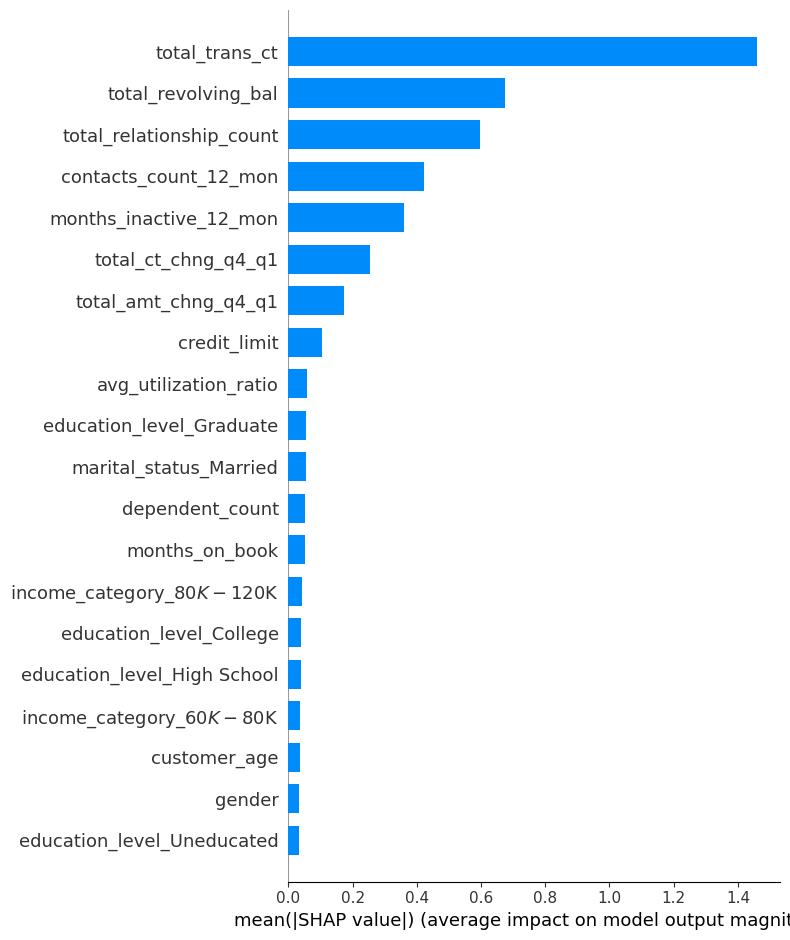

In [ ]:
xgb_shap_values = shap.TreeExplainer(xgb_best).shap_values(X_train)

shap.summary_plot(xgb_shap_values, X_train, plot_type='bar')

Hasil dati shapley menunjukkan sedikit perbedaan pada peringkat impact yang diberikan oleh features. Peringkat pertama masih sama dengan permutation feature importance. Akan tetapi peringkat kedua dan ketiga saling bertukar posisi. Menurut shapley, total_revolving_bal lebih berdampak daripada total_relationship_count berbeda dengan hasil dari permutation feature importance yang mengatakan sebaliknya. Perbedaan posisi peringkat dampak ini juga terjadi pada peringkat keempat dan kelima dimana contacts_count_12_mon lebih berdampak daripada months_inactive_12_mon.

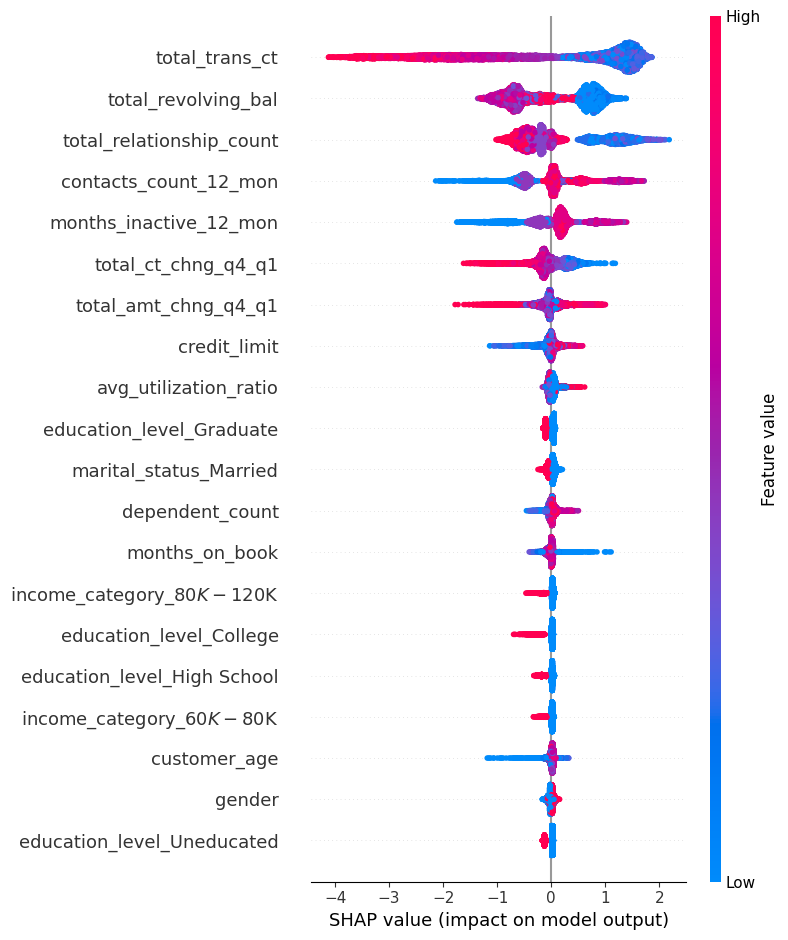

In [ ]:
shap.summary_plot(xgb_shap_values, X_train)

Selaras dengan visualisasi boxplot dalam hal peringkat pengaruh, feature yang paling berpengaruh adalah total_trans_ct dan yang paling tidak terlalu berpengaruh adalah education_level_Uneducated. Sebaran pada sumbu x menunjukkan arah dari dampak fitur terhadap prediksi. Sesuai dengan perhitungan sebelumnya, total_trans_ct cenderung memiliki negative impact karena terdapat banyak titik di arah negatif. Warna merah menunjukkan kuatnya pengaruh tersebut. Sedangkan untuk feature yang lain masih bervariasi dan bahkan hampir seimbang kecuali beberapa kolom seperti pada total_relationship_count yang masih memiliki lebih banyak titik pada sisi positif.

## Shapley Dependence Plot

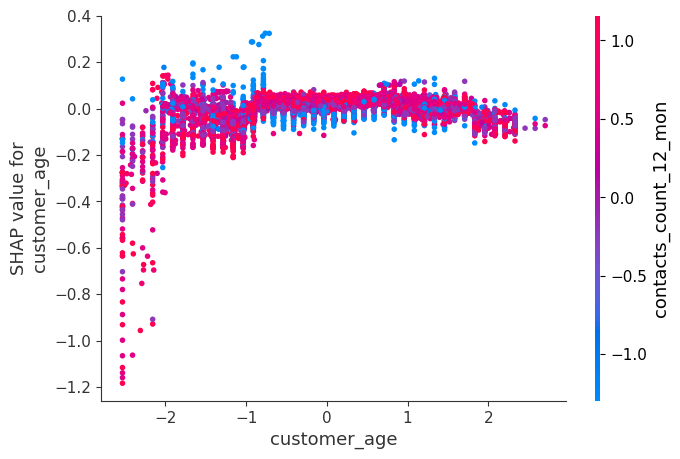

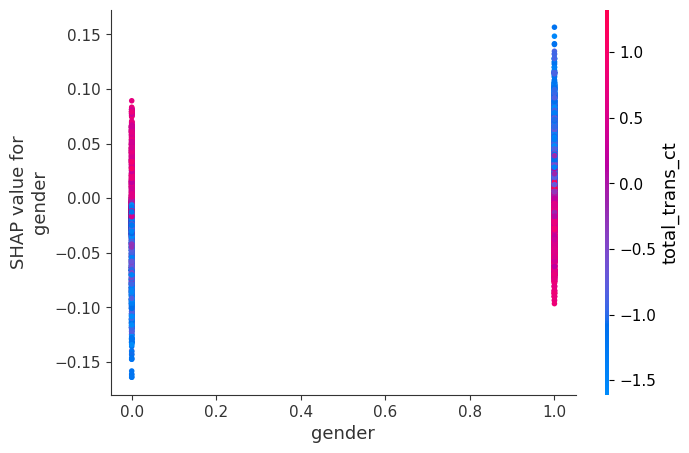

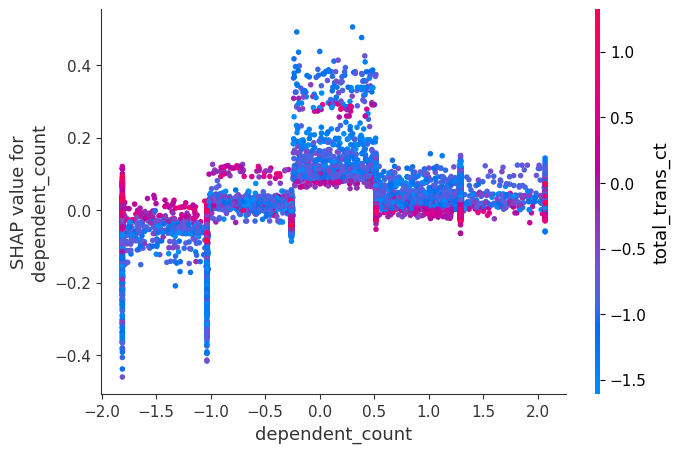

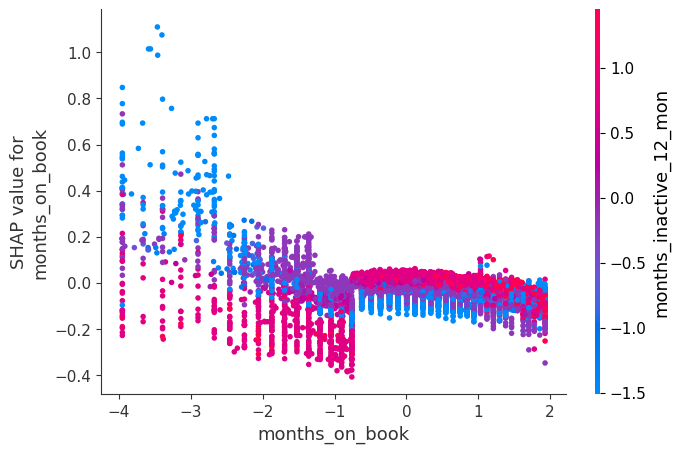

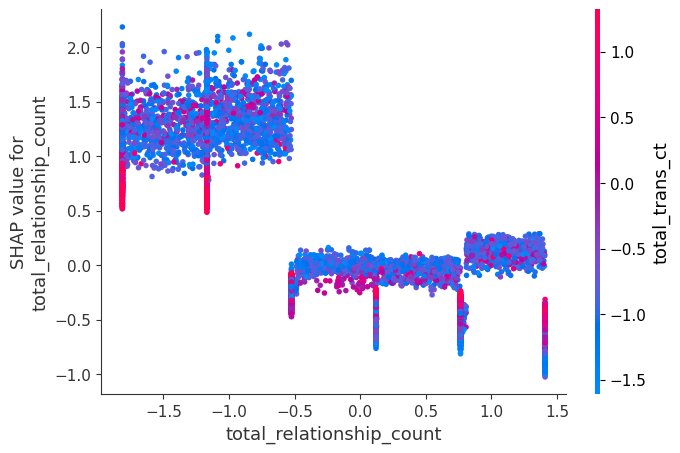

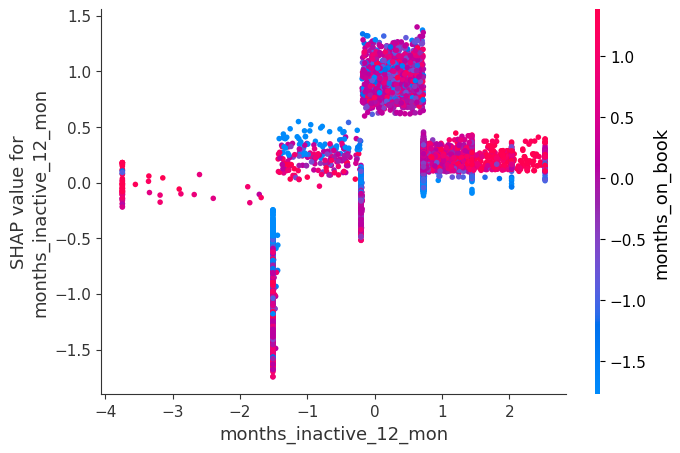

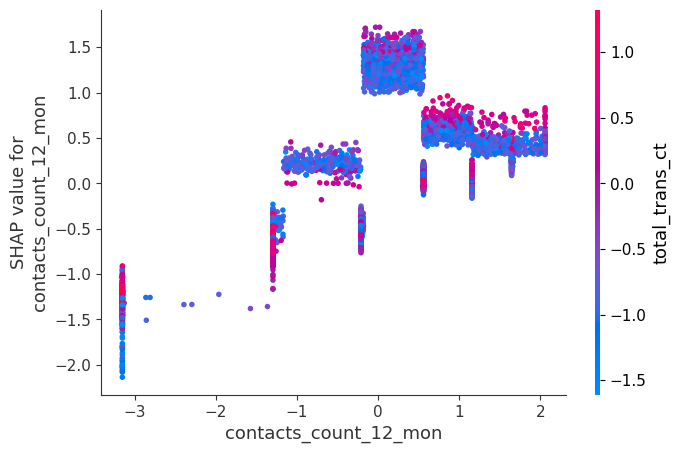

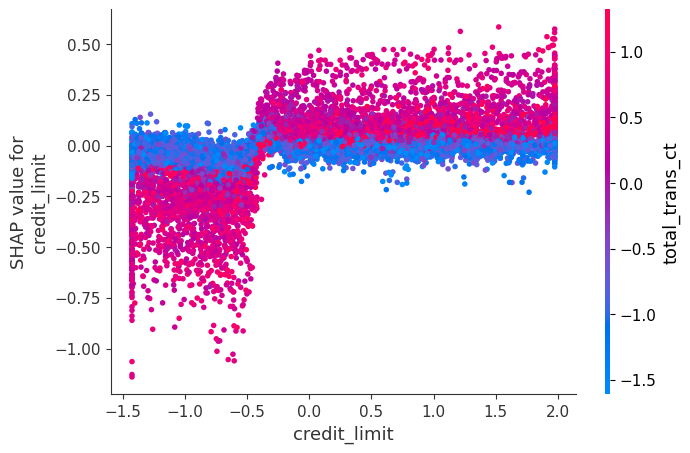

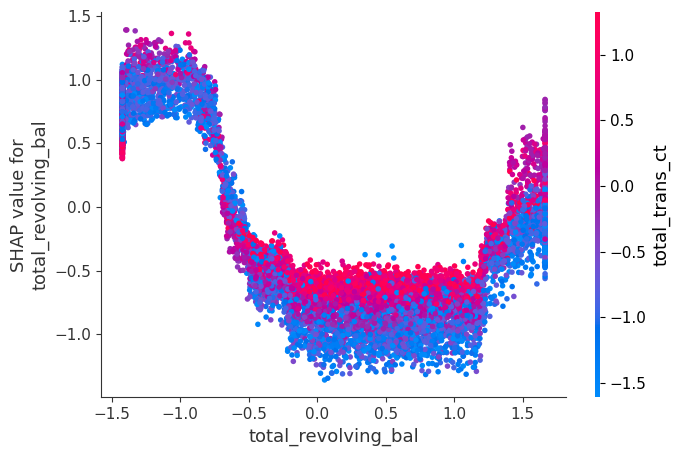

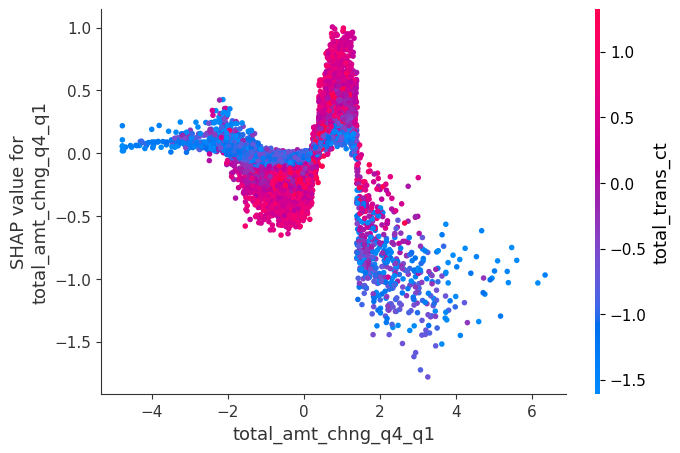

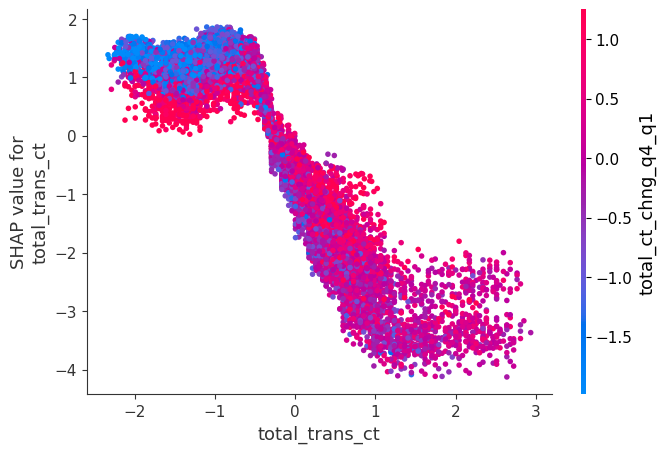

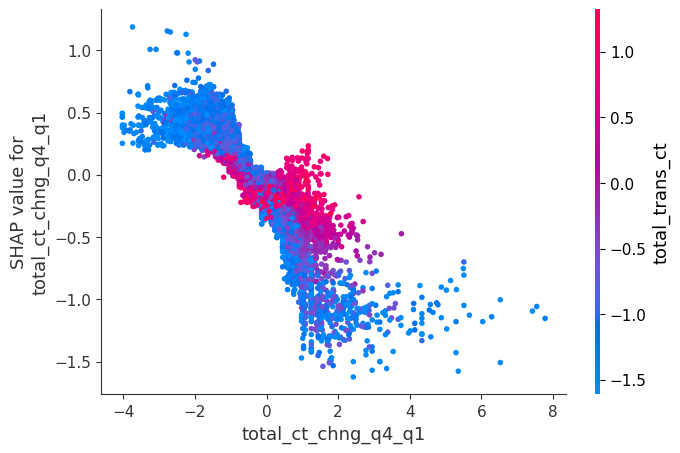

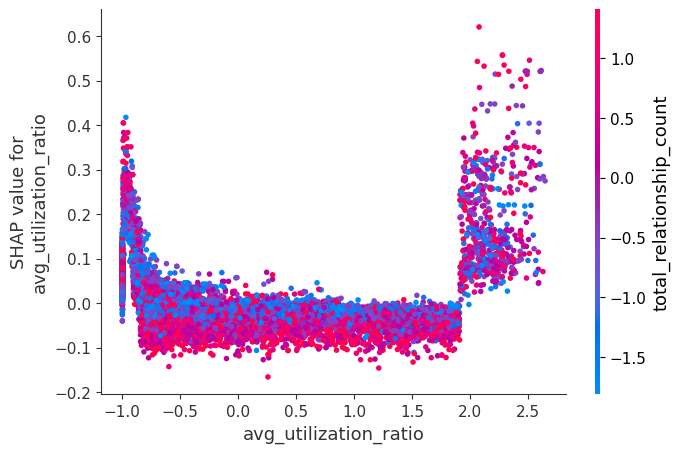

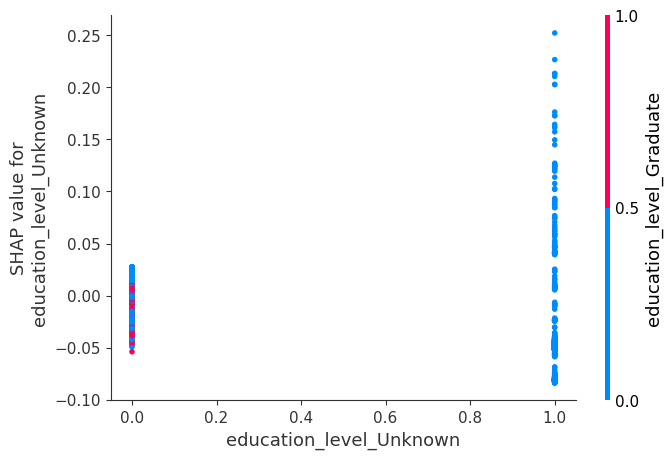

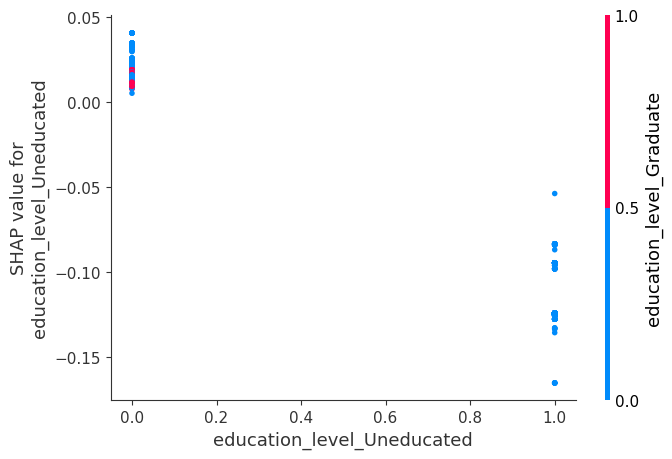

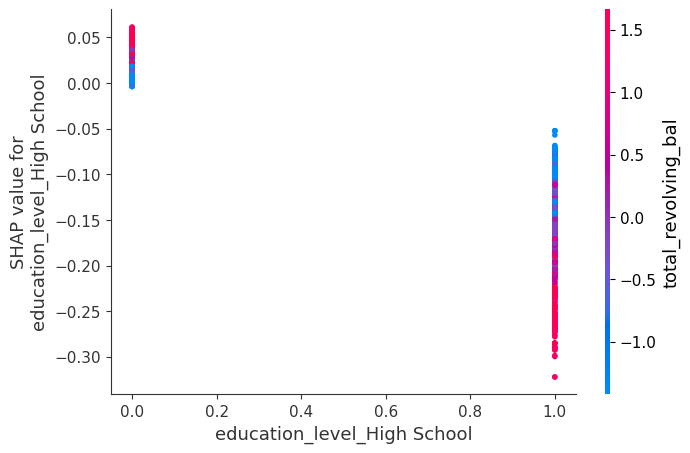

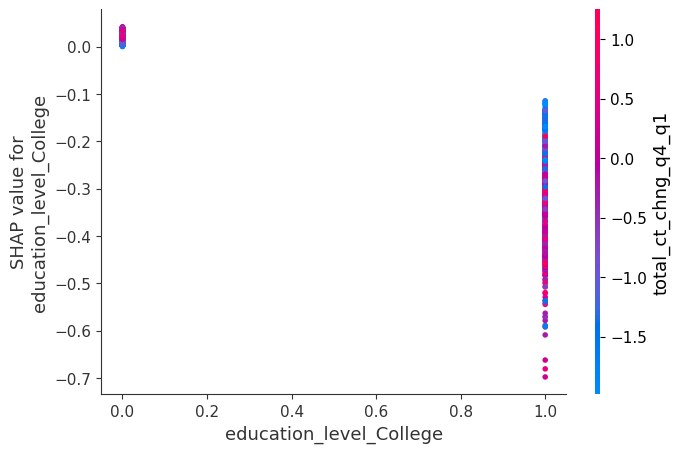

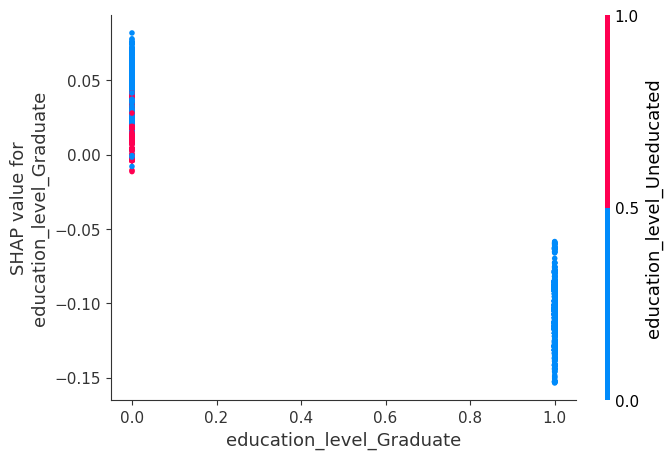

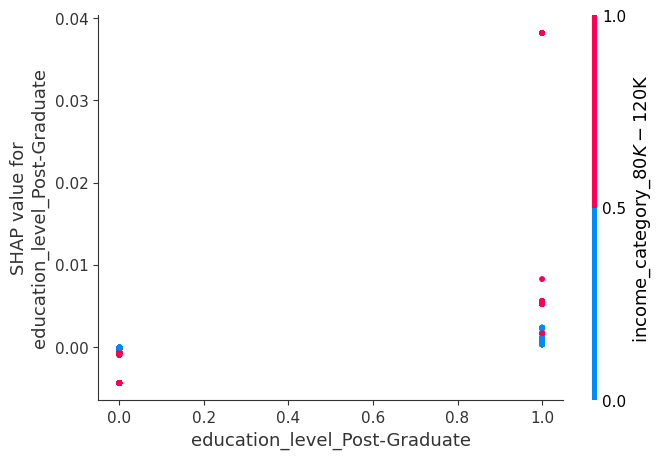

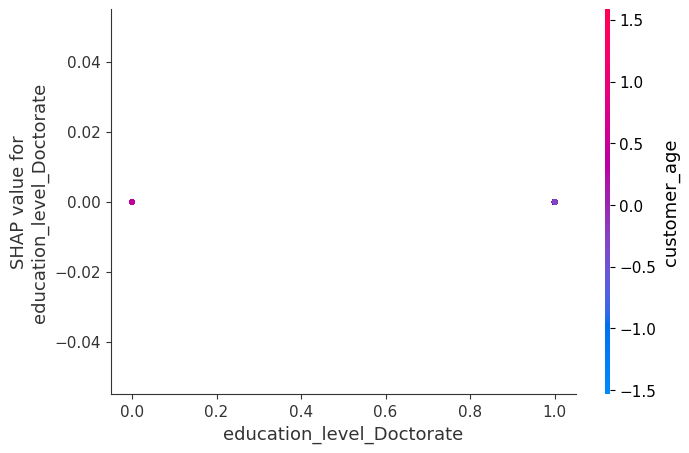

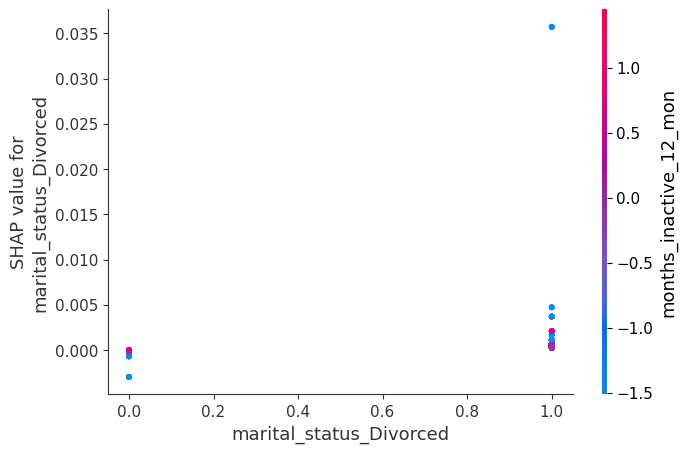

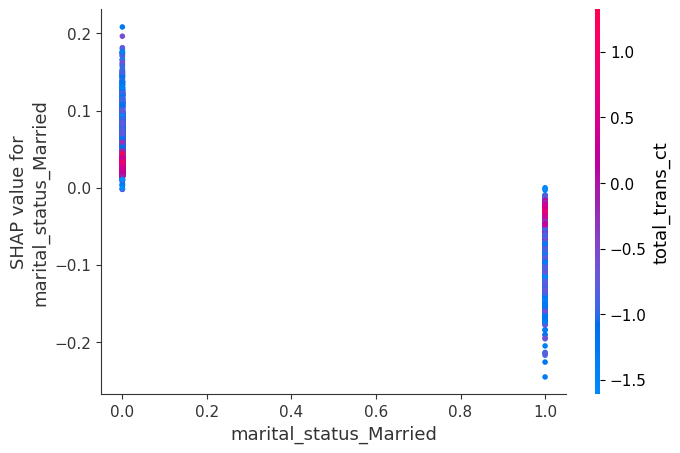

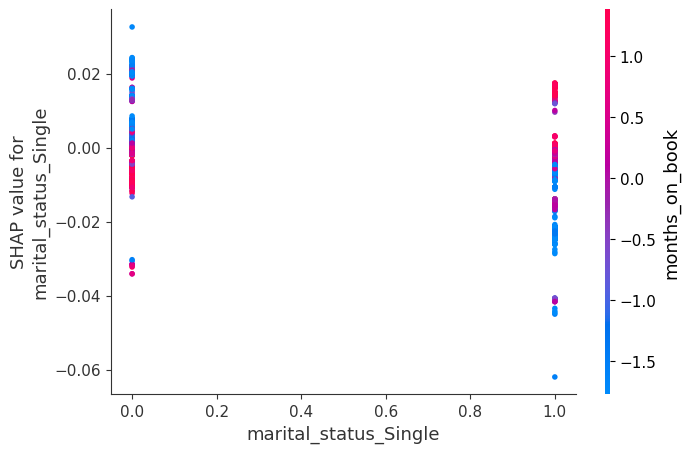

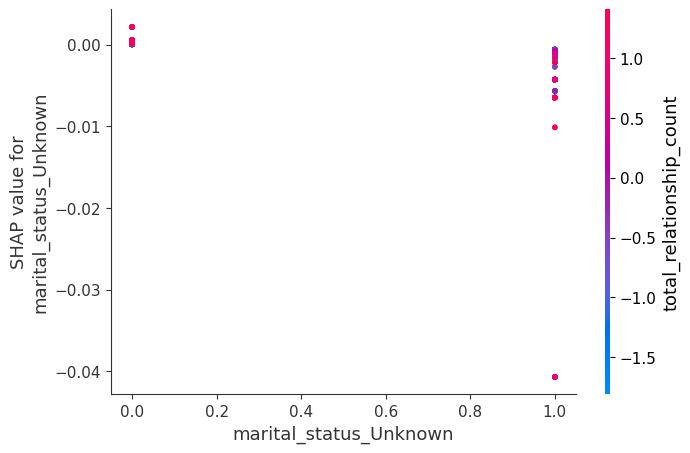

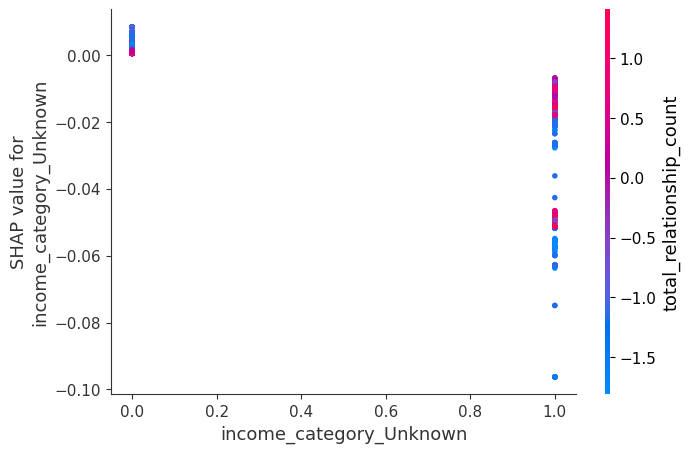

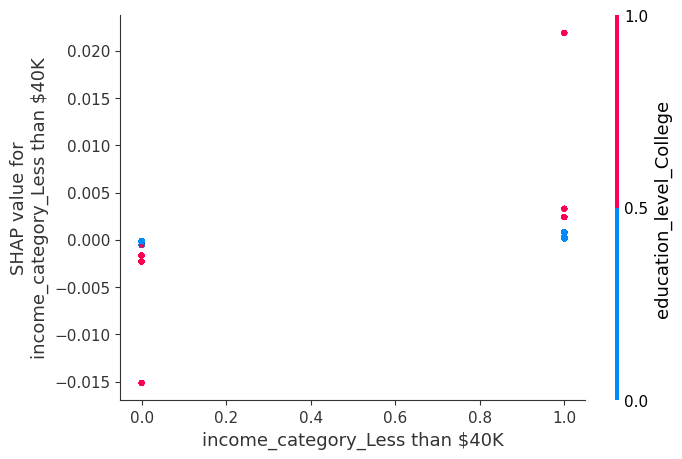

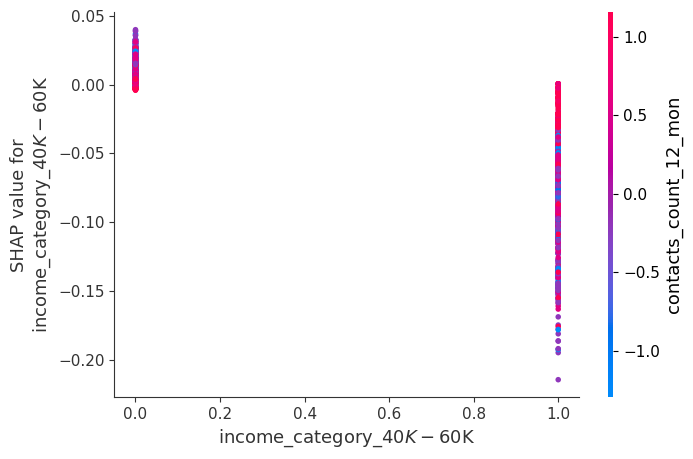

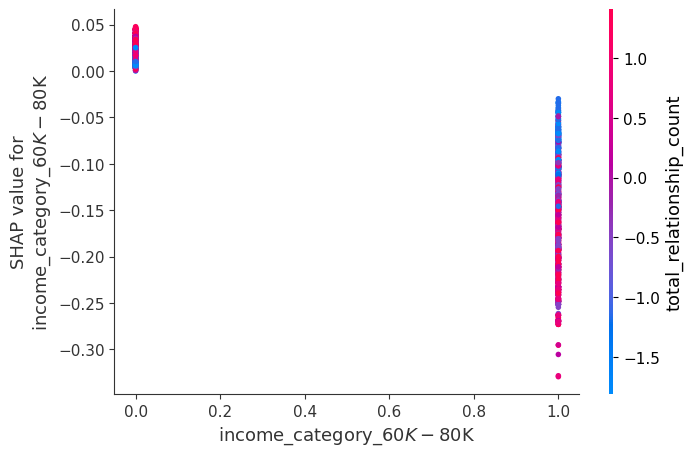

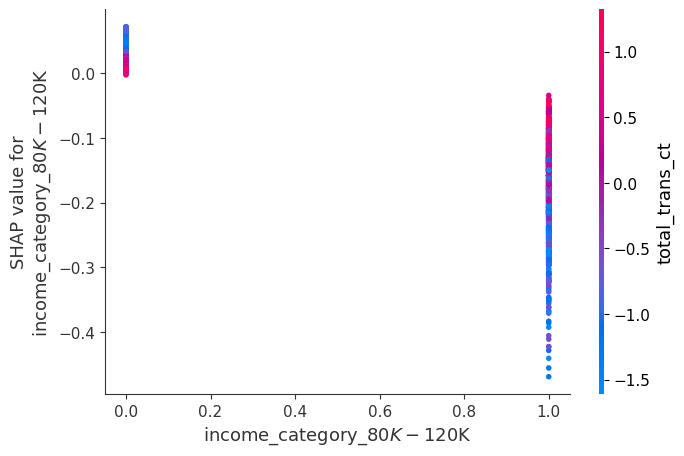

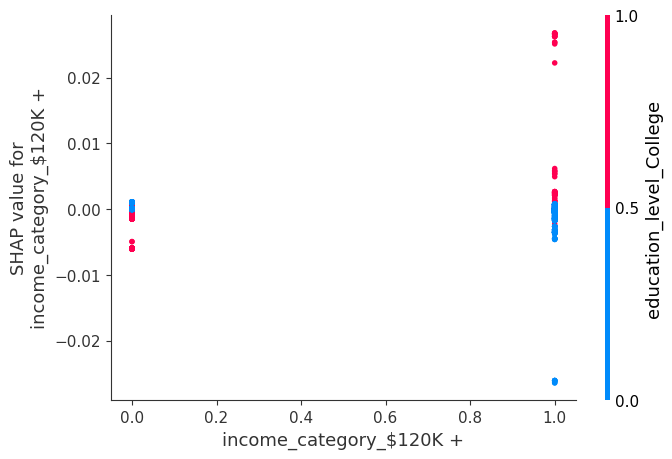

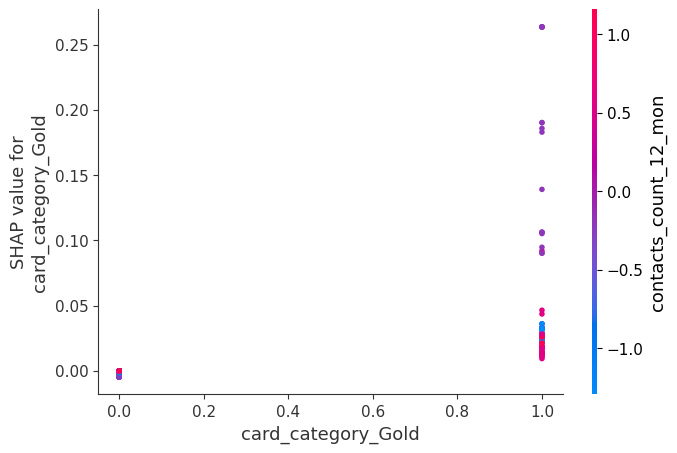

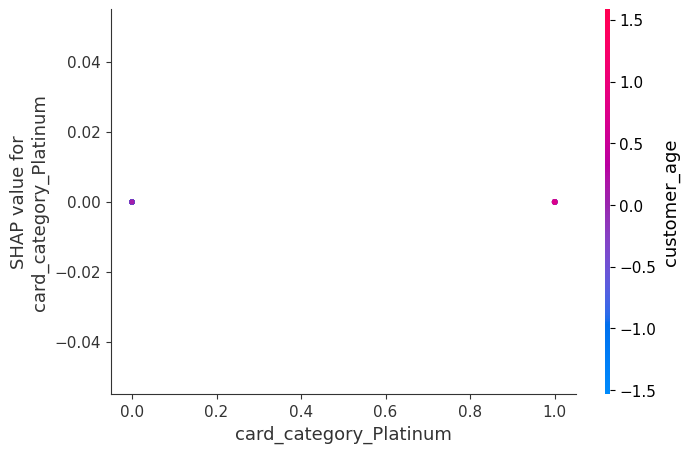

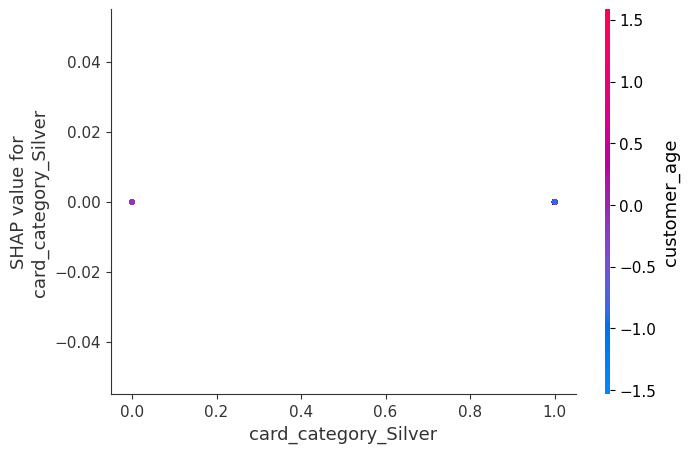

In [ ]:
feature_names = X_train.columns
for i in range(X_train.shape[1]):
  shap.dependence_plot(
      ind=i,
      shap_values=xgb_shap_values,
      features=X_train,
      feature_names=feature_names
  )

Pada visualisasi ini kita tidak mengatur parameter interaction_index pada shap.dependence_plot sehingga method akan memilih feature yang berinteraksi kuat dengan feature yang divisualisasikan. Sebagai contoh, pada dependence plot customer_age feature terkuat yang berinteraksi terhadap customer_age adalah contacts_count_12_mon yang menjadi hue dari setiap titiknya. Visualisasi ini menunjukkan dampak positif pada rentang -3 sampai -2 dan cenderung konstan atau tidak berdampak pada rentang sisanya. Selain itu, titik warna merah yang mendominasi plot menunjukkan bahwa customer_age yang memiliki contacts_count_12_mon tinggi sangat berpengaruh pada prediction. Dengan cara yang sama kita bisa membaca pengaruh feature lain beserta pasangan featurenya terhadap prediction. Seperti pada total_revolving_bal yang memiliki negative impact pada rentang -1 sampai 0 dan positive impact pada rentang 1 ke atas. Terlihat juga ada feature yang hanya terpusat pada titik 0 dan 1 yang menunjukkan bahwa kolom tersebut adalah data kategorikal.

## Rekomendasi

1. Mengingat data yang imbalance, sebaiknya kita perlu menambah data customer yang churn dan fokus untuk tidak menambah data yang memiliki missing value pada kolom - kolom yang memiliki impact besar pada model seperti total_trans_ct, total_relationship_count, total_revolving_bal, months_inactive_12_mon, dll.

2. Kita bisa mempertimbangkan untuk menghapus kolom - kolom yang memiliki impact lemah seperti education_level_Uneducated, gender, customer_age, dll.

3. Kita bisa mempertimbangkan untuk menggabungkan pasangan feature yang kuat sebagaimana dijelaskan pada shapley dependence plot seperti total_amt_chng_q4_q1 dengan total_trans_ct karena keduanya saling menguatkan. Contoh lain adalah pasangan months_on_book dan months_inactive_12_mon yang keduanya juga saling menguatkan pada visualisasi shapley dependence plot.